# Notebook 5: Identify Route Parish Intersections

## Introduction to Noteboook 5

Why are route-parish intersections important? https://cw.fel.cvut.cz/b181/_media/courses/cg/lectures/09-intersect.pdf



In [1]:
import osmnx as ox, csv

with open('overpass-api.csv', mode='r') as infile:
    reader = csv.reader(infile)
    overpass_api = {rows[0]:rows[1] for rows in reader}

ox.config(
    log_console=False, 
    use_cache=True, 
    log_file=True,
    overpass_endpoint=overpass_api['main']
)

In [2]:
%%time
if 'G_proj' not in globals():
    G_proj = ox.load_graphml('data/g_projected.graphml')

if 'G' not in globals():
    G = ox.load_graphml('data/g_unprojected.graphml')

CPU times: user 49.5 s, sys: 1.95 s, total: 51.5 s
Wall time: 51.6 s


## Data sources

In [3]:
import pandas as pd, geopandas as gpd, folium

pd.options.display.float_format = '{:.10f}'.format

### Paired cache GDF, parishes GDF

In [4]:
parishes_gdf = gpd.read_file('data/parishes_gdf.gpkg')
paired_cache_df = pd.read_pickle('data/paired_cache_df.pickle')

In [5]:
parishes_gdf

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
0,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.1_1,Bukesa,None,Parish,Parish,None,559768.3975113713,451524.4166484834,35906.9724917396,"MULTIPOLYGON (((32.56321 0.31958, 32.56292 0.3..."
1,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.2_1,Civic Centre,None,Parish,Parish,None,1209455.8146584448,453884.4876301024,34880.4453069279,"MULTIPOLYGON (((32.57724 0.30992, 32.57730 0.3..."
2,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.3_1,Industrial Area,None,Parish,Parish,None,1776410.1888785006,455890.3457818955,35463.5391795589,"MULTIPOLYGON (((32.60664 0.31585, 32.60598 0.3..."
3,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.4_1,Kagugube,None,Parish,Parish,None,502708.6719317246,452030.8561209833,36273.6179740557,"MULTIPOLYGON (((32.57084 0.32427, 32.57058 0.3..."
4,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.5_1,Kamwokya I,None,Parish,Parish,None,411428.6768850168,454564.2625147337,38168.9266840897,"MULTIPOLYGON (((32.58500 0.34132, 32.58651 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.9_1,Nakulabye,None,Parish,Parish,None,1026084.8535207716,450559.2039879204,36410.2678852486,"MULTIPOLYGON (((32.54860 0.33223, 32.55151 0.3..."
92,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.10_1,Namirembe,None,Parish,Parish,None,1859599.6021243334,450911.3264704965,35032.9390910053,"MULTIPOLYGON (((32.56114 0.30923, 32.56108 0.3..."
93,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.11_1,Nateete,None,Parish,Parish,None,1804795.3528157354,448176.4503960741,33820.1469633023,"MULTIPOLYGON (((32.54007 0.30528, 32.53991 0.3..."
94,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.12_1,Ndeeba,None,Parish,Parish,None,1962463.6518844925,451649.7161646702,33182.2916360861,"MULTIPOLYGON (((32.57188 0.29548, 32.57166 0.2..."


## Create GDF from paired cache DF

In [6]:
import yaml

with open("proj_crs.yml", "r") as stream:
    try:
        epsg_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
proj_epsg_str = str(epsg_dict).replace("{","").replace("}", "").replace("'","").replace(" ","")

print('Projected graph EPSG code:',proj_epsg_str)

Projected graph EPSG code: EPSG:32636


In [7]:
paired_cache_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_node          10 non-null     int64  
 1   parish_name     10 non-null     object 
 2   r_node_lat      10 non-null     float64
 3   r_node_lon      10 non-null     float64
 4   prj_lat         10 non-null     float64
 5   prj_lon         10 non-null     float64
 6   t_node          10 non-null     int64  
 7   t_node_lat      10 non-null     float64
 8   t_node_lon      10 non-null     float64
 9   PRJ_LAT         10 non-null     float64
 10  PRJ_LON         10 non-null     float64
 11  d1              10 non-null     float64
 12  d2              10 non-null     float64
 13  path_node_list  10 non-null     object 
 14  d3_euc          10 non-null     float64
 15  d3_path_sum     10 non-null     float64
 16  d3_shapely      10 non-null     object 
 17  d3_edge_attrs   10 non-null     float6

In [8]:
%%time
from oxtools.compute_d3 import nodes_to_linestring

paired_cache_df['geometry'] = paired_cache_df['path_node_list'].map(\
            lambda x: nodes_to_linestring(x, G_proj))

CPU times: user 3.61 ms, sys: 1.47 ms, total: 5.08 ms
Wall time: 4.23 ms


In [9]:
paired_cache_gdf = gpd.GeoDataFrame(paired_cache_df, geometry='geometry', crs=proj_epsg_str)

paired_cache_gdf

,r_node,parish_name,r_node_lat,r_node_lon,prj_lat,prj_lon,t_node,t_node_lat,t_node_lon,PRJ_LAT,PRJ_LON,d1,d2,path_node_list,d3_euc,d3_path_sum,d3_shapely,d3_edge_attrs,d_total,geometry
0,475033488,Kisugu,0.3109017000,32.6098430000,34360.8727358355,456562.9815281392,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,22.9457818662,84.0904376390,"[475033488, 1583799847, 475033491, 3481960627,...",1694.6835003641,2617.9292724860,LINESTRING (456585.59137818636 34364.784715679...,2622.6930000000,2729.7292195052,"LINESTRING (456585.591 34364.785, 456611.507 3..."
1,579992646,Kisugu,0.3055115000,32.6048523000,33769.9961761353,456041.6049933219,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,11.4231693408,8.1925049479,"[579992646, 6226995197, 8145150031, 6226995198...",1850.5142124157,2846.9235105639,LINESTRING (456030.2243100812 33769.0118759969...,2851.0360000000,2870.6516742886,"LINESTRING (456030.224 33769.012, 456002.839 3..."
2,579992650,Kisugu,0.3053494000,32.6058468000,33773.6460562803,456149.2418963615,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,24.0530212551,8.1925049479,"[579992650, 6226995049, 6226995048, 6226995046...",1954.9027932762,2973.9905875952,LINESTRING (456140.8876837517 33751.0904591219...,2977.0970000000,3009.3425262029,"LINESTRING (456140.888 33751.090, 456123.128 3..."
3,579993375,Kisugu,0.3082407000,32.6077652000,34099.9887480836,456348.1643899938,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,29.9726741560,84.0904376390,"[579993375, 579993374, 579993373, 6226994993, ...",1864.5203716102,3031.4086806217,LINESTRING (456354.3713367001 34070.6658047005...,3037.0040000000,3151.0671117949,"LINESTRING (456354.371 34070.666, 456373.700 3..."
4,579993404,Kisugu,0.3097587000,32.6091322000,34242.2791634763,456485.6911287252,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,21.1503781451,84.0904376390,"[579993404, 1583799967, 1583799788, 1583799935...",1745.8336543244,2730.6216586954,LINESTRING (456506.49177350843 34238.448801576...,2735.6840000000,2840.9248157841,"LINESTRING (456506.492 34238.449, 456532.709 3..."
5,1425900085,Kisugu,0.3064335000,32.6088976000,33876.6310349672,456513.8083599660,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,33.9219259997,84.0904376390,"[1425900085, 1425899988, 1425900082, 579993366...",1694.0858067379,3230.5568852372,LINESTRING (456480.3729432435 33870.9065286897...,3237.2020000000,3355.2143636386,"LINESTRING (456480.373 33870.907, 456556.398 3..."
6,1583799787,Kisugu,0.3100471000,32.6100813000,34265.1114668231,456597.0991967148,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,15.8848284194,84.0904376390,"[1583799787, 6227589978, 1583800118, 158380034...",1640.4063742119,2677.1014087277,LINESTRING (456612.1049491421 34270.3225289032...,2682.0780000000,2782.0532660583,"LINESTRING (456612.105 34270.323, 456606.586 3..."
7,1623680456,Kisugu,0.3034371000,32.6069466000,33543.4285311180,456235.1282905157,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,28.3771980662,8.1925049479,"[1623680456, 6227266310, 6227266309, 622726630...",1990.0271090947,2986.9322720425,LINESTRING (456263.2613652091 33539.7143046327...,2989.4360000000,3026.0057030141,"LINESTRING (456263.261 33539.714, 456297.791 3..."
8,6227266299,Kisugu,0.3045855000,32.6082708000,33676.9179346887,456382.5662585886,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,29.8734513255,8.1925049479,"[6227266299, 6227266298, 579993288, 6227266296...",2158.7852848884,2988.6203467860,LINESTRING (456410.61770218826 33666.644687584...,2991.7800000000,3029.8459562733,"LINESTRING (456410.618 33666.645, 456413.978 3..."
9,8144996943,Kisugu,0.3033524000,32.6059574000,33539.3529249087,456137.4533565310,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,18.1240432856,8.1925049479,"[8144996943, 8144996944, 5799926

### Change GDF projection

In [10]:
paired_cache_proj_gdf = paired_cache_gdf.to_crs(proj_epsg_str)
parishes_proj_gdf = parishes_gdf.to_crs(proj_epsg_str)

### Add two new columns

In [11]:
paired_cache_proj_gdf['parish_route'] = ''
paired_cache_proj_gdf['parish_num'] = 0

In [12]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,prj_lat,prj_lon,t_node,t_node_lat,t_node_lon,PRJ_LAT,...,d2,path_node_list,d3_euc,d3_path_sum,d3_shapely,d3_edge_attrs,d_total,geometry,parish_route,parish_num
0,475033488,Kisugu,0.3109017000,32.6098430000,34360.8727358355,456562.9815281392,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[475033488, 1583799847, 475033491, 3481960627,...",1694.6835003641,2617.9292724860,LINESTRING (456585.59137818636 34364.784715679...,2622.6930000000,2729.7292195052,"LINESTRING (456585.591 34364.785, 456611.507 3...",,0
1,579992646,Kisugu,0.3055115000,32.6048523000,33769.9961761353,456041.6049933219,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992646, 6226995197, 8145150031, 6226995198...",1850.5142124157,2846.9235105639,LINESTRING (456030.2243100812 33769.0118759969...,2851.0360000000,2870.6516742886,"LINESTRING (456030.224 33769.012, 456002.839 3...",,0
2,579992650,Kisugu,0.3053494000,32.6058468000,33773.6460562803,456149.2418963615,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992650, 6226995049, 6226995048, 6226995046...",1954.9027932762,2973.9905875952,LINESTRING (456140.8876837517 33751.0904591219...,2977.0970000000,3009.3425262029,"LINESTRING (456140.888 33751.090, 456123.128 3...",,0
3,579993375,Kisugu,0.3082407000,32.6077652000,34099.9887480836,456348.1643899938,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993375, 579993374, 579993373, 6226994993, ...",1864.5203716102,3031.4086806217,LINESTRING (456354.3713367001 34070.6658047005...,3037.0040000000,3151.0671117949,"LINESTRING (456354.371 34070.666, 456373.700 3...",,0
4,579993404,Kisugu,0.3097587000,32.6091322000,34242.2791634763,456485.6911287252,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993404, 1583799967, 1583799788, 1583799935...",1745.8336543244,2730.6216586954,LINESTRING (456506.49177350843 34238.448801576...,2735.6840000000,2840.9248157841,"LINESTRING (456506.492 34238.449, 456532.709 3...",,0
5,1425900085,Kisugu,0.3064335000,32.6088976000,33876.6310349672,456513.8083599660,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[1425900085, 1425899988, 1425900082, 579993366...",1694.0858067379,3230.5568852372,LINESTRING (456480.3729432435 33870.9065286897...,3237.2020000000,3355.2143636386,"LINESTRING (456480.373 33870.907, 456556.398 3...",,0
6,1583799787,Kisugu,0.3100471000,32.6100813000,34265.1114668231,456597.0991967148,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[1583799787, 6227589978, 1583800118, 158380034...",1640.4063742119,2677.1014087277,LINESTRING (456612.1049491421 34270.3225289032...,2682.0780000000,2782.0532660583,"LINESTRING (456612.105 34270.323, 456606.586 3...",,0
7,1623680456,Kisugu,0.3034371000,32.6069466000,33543.4285311180,456235.1282905157,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[1623680456, 6227266310, 6227266309, 622726630...",1990.0271090947,2986.9322720425,LINESTRING (456263.2613652091 33539.7143046327...,2989.4360000000,3026.0057030141,"LINESTRING (456263.261 33539.714, 456297.791 3...",,0
8,6227266299,Kisugu,0.3045855000,32.6082708000,33676.9179346887,456382.5662585886,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[6227266299, 6227266298, 579993288, 6227266296...",2158.7852848884,2988.6203467860,LINESTRING (456410.61770218826 33666.644687584...,2991.7800000000,3029.8459562733,"LINESTRING (456410.618 33666.645, 456413.978 3...",,0
9,8144996943,Kisugu,0.3033524000,32.6059574000,33539.3529249087,456137.4533565310,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[8144996943, 8144996944, 579992620, 579992609,...",1892.8943434713,2774.3196406058,LINESTRING (456153.18675021204 33530.356188372...,2776.6460000000,2802.9625482335,"LINESTRING (456153.187 33530.356, 456137.242 3...",,0


References:
1. Convex Hull: https://geopandas.org/docs/user_guide/geometric_manipulations.html#GeoSeries.convex_hull
2. Distance between geoseries: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.distance.html#geopandas.GeoSeries.distance
3. Geoseries contains: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.contains.html#

## Set Parish GDF index to `NAME_4` (parish name)

In [13]:
parishes_proj_gdf = parishes_proj_gdf.set_index(['NAME_4'])

In [14]:
parishes_proj_gdf.loc[['Kisugu']]

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
NAME_4,,,,,,,,,,,,,,,,,
Kisugu,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.3_1,Makindye,UGA.16.1.3.11_1,None,Parish,Parish,None,1227491.9265254766,456230.4708387037,34104.6820534491,"MULTIPOLYGON (((456229.976 33480.017, 456139.1..."


## Identify route-parish intersections and parish routes

In [15]:
parishes = [ row.Index for row in parishes_proj_gdf.itertuples() ]

In [16]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,t_node,t_node_lat,t_node_lon,d3_euc,d3_shapely,path_node_list,...,d1,d2,d3,prj_lat,prj_lon,PRJ_LAT,PRJ_LON,geometry,parish_route,parish_num
0,6224792359,Kabowa,0.2873915000,32.5623252000,5572008964,0.2883498000,32.5594612000,246.4599184290,764.8577704742,"[6224792359, 557330540, 557330539, 557330554, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451297.885 31766.331, 451300.567 3...",,0
1,6241486007,Kabowa,0.2910965000,32.5589864000,5572008964,0.2883498000,32.5594612000,306.8949496724,489.8071930412,"[6241486007, 6241486005, 6100868024, 493323985...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450926.369 32175.872, 450924.132 3...",,0
2,2085397292,Kabowa,0.2852278000,32.5606116000,5572008964,0.2883498000,32.5594612000,367.1917534631,571.3800720441,"[2085397292, 2085397298, 2085397289, 208539729...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451107.191 31527.178, 451085.692 3...",,0
3,7100592251,Kabowa,0.2925402000,32.5509825000,5572008964,0.2883498000,32.5594612000,1079.1479627214,1401.1835808965,"[7100592251, 7100592252, 7100592253, 710059225...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450035.726 32335.484, 450039.866 3...",,0
4,6229407820,Kabowa,0.2911225000,32.5589936000,5572008964,0.2883498000,32.5594612000,304.2698779717,492.7906517788,"[6229407820, 6241486007, 6241486005, 610086802...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450927.171 32178.746, 450926.369 3...",,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,6213151721,Mutundwe,0.2781923000,32.5400341000,5572008964,0.2883498000,32.5594612000,2450.7139278784,LINESTRING (448817.3573167607 30749.6076976613...,"[6213151721, 6213151722, 6213151723, 809625964...",...,15.6487307896,30.9127230872,NaN,30763.4974547303,448824.5654665851,31872.2887513557,451010.1044428619,"LINESTRING (448817.357 30749.608, 448820.640 3...",,0
70,6225392068,Mutundwe,0.2800148000,32.5444677000,5572008964,0.2883498000,32.5594612000,1961.4108512061,LINESTRING (449310.72386884096 30951.036026065...,"[6225392068, 6225392069, 6225392070, 557315093...",...,28.8820607025,30.9127230872,NaN,30942.2524388433,449283.2098355863,31872.2887513557,451010.1044428619,"LINESTRING (449310.724 30951.036, 449311.626 3...",,0
71,6225526253,Mutundwe,0.2871910000,32.5451966000,5572008964,0.2883498000,32.5594612000,1617.1432260912,LINESTRING (449391.8649700851 31744.2439457506...,"[6225526253, 6226887750, 1242682715, 557345641...",...,8.0291349359,30.9127230872,NaN,31749.8610510506,449397.6021415021,31872.2887513557,451010.1044428619,"LINESTRING (449391.865 31744.244, 449396.494 3...",,0
72,7103214804,Mutundwe,0.2860457000,32.5470935000,5572008964,0.2883498000,32.5594612000,1426.4104372214,LINESTRING (449602.9414741557 31617.6414895286...,"[7103214804, 7105675803, 7105675698, 557314191...",...,4.6742574429,30.9127230872,NaN,31615.3640677507,449607.0233894767,31872.2887513557,451010.1044428619,"LINESTRING (449602.941 31617.641, 449621.136 3...",,0


In [15]:
%%time
from shapely.geometry import Point
from tqdm import tqdm, notebook
from oxtools.compute_d3 import get_parish_route
# tqdm parameters
total_rows=paired_cache_proj_gdf.shape[0]

# route loop
for r_row in tqdm(paired_cache_proj_gdf.itertuples(), total=total_rows):

    # parishes intersected by route
    parish_list = [ p_row.Index for p_row in parishes_proj_gdf.itertuples() \
                   if r_row.geometry.distance(p_row.geometry.convex_hull) == 0 ]
    # go through path nodes to get right order of parishes (parish_route)
    parish_route = get_parish_route(r_row.path_node_list, parishes_proj_gdf, parish_list, G_proj)
    paired_cache_proj_gdf.at[r_row.Index, 'parish_route'] = parish_route
    paired_cache_proj_gdf.at[r_row.Index, 'parish_num'] = len(parish_route)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]

CPU times: user 3.12 s, sys: 76.6 ms, total: 3.2 s
Wall time: 3.22 s


<AxesSubplot:title={'center':'Sample Residence-to-Test-Facility Routes through Parishes in Kampala'}>

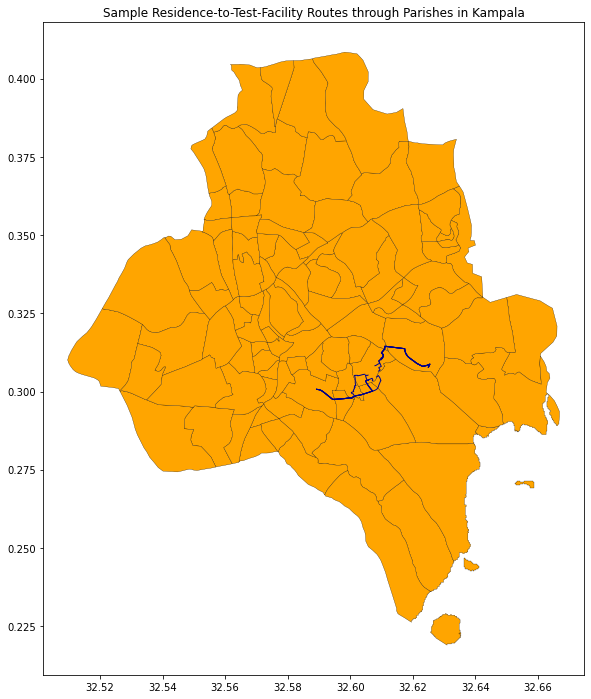

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(24, 12))
plt.title('Sample Residence-to-Test-Facility Routes through Parishes in Kampala')
parishes_gdf.plot(ax=ax1, color='orange', edgecolor='black', linewidth=0.25)
paired_cache_proj_gdf.to_crs('EPSG:4326').plot(ax=ax1, color='darkblue', linewidth=1)

In [17]:
paired_cache_proj_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   r_node          10 non-null     int64   
 1   parish_name     10 non-null     object  
 2   r_node_lat      10 non-null     float64 
 3   r_node_lon      10 non-null     float64 
 4   prj_lat         10 non-null     float64 
 5   prj_lon         10 non-null     float64 
 6   t_node          10 non-null     int64   
 7   t_node_lat      10 non-null     float64 
 8   t_node_lon      10 non-null     float64 
 9   PRJ_LAT         10 non-null     float64 
 10  PRJ_LON         10 non-null     float64 
 11  d1              10 non-null     float64 
 12  d2              10 non-null     float64 
 13  path_node_list  10 non-null     object  
 14  d3_euc          10 non-null     float64 
 15  d3_path_sum     10 non-null     float64 
 16  d3_shapely      10 non-null     object  
 17  d3_edge_att

In [18]:
paired_cache_proj_gdf[['parish_name', 'parish_num', 'd3_edge_attrs']].groupby(['parish_name']).mean()

,parish_num,d3_edge_attrs
parish_name,,
Kisugu,4.3000000000,2890.0656000000


<AxesSubplot:title={'center':'Mean D3 by edge attributes of Selected Kampala Parishes'}, xlabel='parish_name'>

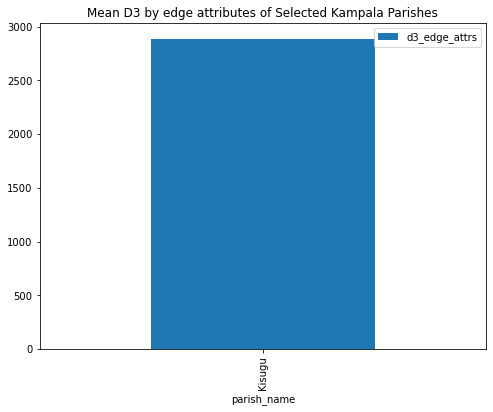

In [29]:
paired_cache_proj_gdf[['parish_name', 'd3_edge_attrs']]\
    .groupby(['parish_name']).mean()\
    .plot.bar(\
              figsize=(8, 6),
              title='Mean D3 by edge attributes of Selected Kampala Parishes')

<AxesSubplot:title={'center':'Number of Parishes Traversed from Residence to Testing Site\n in Selected Kampala Parishes'}, xlabel='parish_name'>

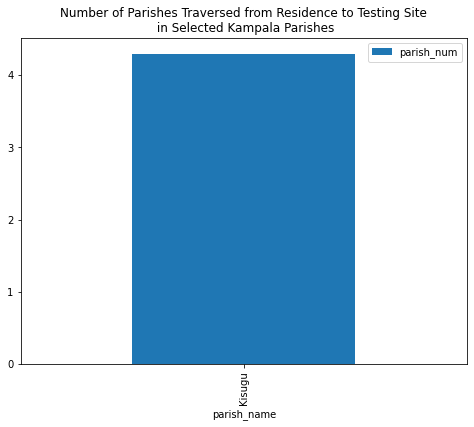

In [34]:
paired_cache_proj_gdf[['parish_name', 'parish_num']]\
    .groupby(['parish_name']).mean()\
    .plot.bar(\
              figsize=(8, 6),
              title='Number of Parishes Traversed from '+\
              'Residence to Testing Site\n in Selected Kampala Parishes')